# Am I the AHole Dataset Construction

Constructing datasets for the AITA subreddit as an exercise using AllenNLP.

In [1]:
import sys
sys.path.append('.')
sys.path.append('..')

from subreddit_frequency import load_dataframe_from_jsonl
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
from datetime import datetime
sns.set('paper')

from ipywidgets import interact
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Data Loading

Loads the data from sharded files, need to rebuild and concatonate.
May take up a lot of memory, so runon a computer with enough RAM.

In [2]:
submissions_df = pd.concat([
    load_dataframe_from_jsonl(a)
    for a in Path("../data").glob("RS_*")
],axis=0)

7561it [00:00, 22781.51it/s]


In [3]:
comments_df = pd.concat([
    load_dataframe_from_jsonl(a)
    for a in Path("../data").glob("RC_*")
],axis=0)

209347it [00:05, 36353.70it/s]


## Dataset Statistics

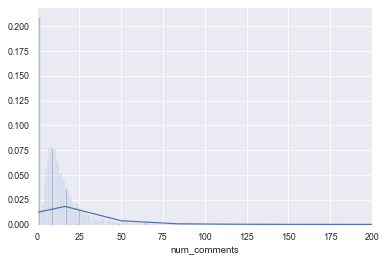

In [4]:
#print(comments_df.created_utc.conve.describe())
sns.distplot(submissions_df.num_comments,bins=5000, kde=True);
plt.xlim(0,200)
plt.show()

In [5]:
submissions_df.score.describe()

count     7561.000000
mean        58.649253
std        531.442131
min          0.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      17150.000000
Name: score, dtype: float64

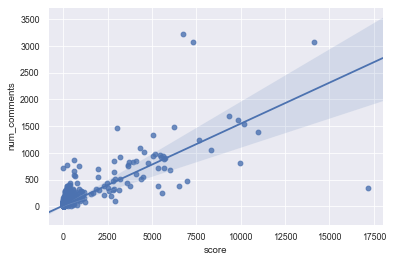

In [7]:
sns.regplot(x='score', y='num_comments', data=submissions_df)
plt.show()

Preprocess the comment to have:
* the id of the previous post that it is a comment to
* the absolute value of the score

## Helper Functions

Helper functions to:
1. Get comments from ID
2. Determine if someone is an AH

In [8]:
def get_comments_from_id(df, parent_id):
    cols = ['author_flair_text', 'stickied', 'author', 'body', 'score', 'score_abs', 'judgement']
    return df[df.prev_id == parent_id][cols]

In [9]:
def determine_AH(body):
    """Determines if poster thinks asshole or not asshole."""
    if body.startswith("YTA"):
        return "YTA"
    elif body.startswith("ESH"):
        return "ESH"
    elif body.startswith("NAH"):
        return "NAH"
    elif body.startswith("NTA"):
        return "NTA"
    else:
        return "UNK"

In [95]:
comments_df['prev_id'] = comments_df.parent_id.map(lambda x: x.split('_')[-1])
comments_df['score_abs'] = comments_df.score.map(abs)
comments_df['judgement'] = comments_df.body.map(determine_AH)
submissions_df['timestamp'] = submissions_df.created_utc.map(datetime.fromtimestamp)
submissions_df = submissions_df.sort_values('num_comments', ascending=False)

Only get the most popular titles with the highest number of comments.

In [96]:
pd.set_option('display.max_rows', 500)
good_submissions_df = submissions_df[submissions_df.num_comments > 30]

In [97]:
len(good_submissions_df)

1072

In [98]:
display(list(good_submissions_df.head().title))
display(list(good_submissions_df.head().id))

['AITA for being mad at my boyfriend for getting a lap dance?',
 "AITA for not wanting to pay for my stepkid's education despite paying for my own kid?",
 'AITA for telling my husband he needs to box up his deceased wife’s stuff so we can move into their old bedroom?',
 "AITA for breaking up with my SO who revealed they're trans",
 'AITA for not wanting a kid that could potential go blind at age 20?']

['a4wgq8', 'a9nsfg', 'a3ix8x', 'aa35ws', 'a2dzn2']

For matching, filter by if the comment actually makes a judgement.

In [99]:
comments_df.judgement.value_counts()

UNK    141574
NTA     40233
YTA     18541
ESH      4590
NAH      4409
Name: judgement, dtype: int64

In [136]:
# Determine label and label_fine for each prev_id
judgement_df = comments_df[comments_df.judgement != "UNK"].reset_index()
for judge in judgement_df.judgement.unique():
    judgement_df[judge] = (judgement_df.judgement == judge).astype(int)
count_df = judgement_df.groupby(['prev_id'])[judgement_df.judgement.unique()].sum()
count_df['label_fine'] = count_df.apply(lambda x : dict(x), axis=1)
count_df['label'] = count_df[judgement_df.judgement.unique()].idxmax(axis=1)
count_df['id'] = count_df.index

In [140]:
good_submissions_df = good_submissions_df.merge(count_df[['label', 'label_fine', 'id']], left_on='id', right_on='id')

When the mode is returned, there will sometimes be ties.
So let's get rid of the ties.

In [142]:
good_submissions_df.head().id

0    a4wgq8
1    a9nsfg
2    a3ix8x
3    aa35ws
4    a2dzn2
Name: id, dtype: object

In [144]:
good_submissions_df.label.value_counts()

NTA    633
YTA    377
ESH     29
NAH     25
Name: label, dtype: int64

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
good_submissions_df[['title', 'label']].head()
print(good_submissions_df[good_submissions_df.label == 'UNK'].title)

In [ ]:
comments_df.head()

In [ ]:
label_counts = good_submissions_df.label.value_counts().to_frame()
label_counts.columns = ['counts']
label_counts['label'] = label_counts.index
sns.barplot(y='label', x='counts', data=label_counts)
plt.plot()

## Train Test Split

Eliminates the posts that have an unknown label, and splits our huge dataset into a train/val/test split.

In [47]:
dataset_df = good_submissions_df[good_submissions_df.label != 'UNK']

In [48]:
test_dataset_df = dataset_df.sample(frac=0.1)

In [49]:
traindev_dataset_df = dataset_df.drop(test_dataset_df.index)

In [50]:
train_dataset_df = traindev_dataset_df.sample(frac=0.8)
dev_dataset_df = traindev_dataset_df.drop(train_dataset_df.index)

In [51]:
dev_dataset_df.to_pickle('../aita/aita-dev.pkl')
train_dataset_df.to_pickle('../aita/aita-train.pkl')
test_dataset_df.to_pickle('../aita/aita-test.pkl')